# Analysing data with Spark

A work by: Elliot Renel and Dorian Goepp.

## Downloading the data

Example command to download all the files for job events, running the downloads in parallel:

```bash
gsutil -m cp gs://clusterdata-2011-2/job_events/* ./job_events/
```

The parallelisation of the download is to take advantage of a high bandwidth internet connection. It would not help if the connection is slow.

As these are compressed with gzip, we need to un-compress them. There is an [easy way](https://stackoverflow.com/questions/16038087/extract-and-delete-all-gz-in-a-directory-linux) to do it for all files at once:

```bash
gunzip *.gz
```

> **Note:** As an afterthought, it might have been helpful to load the data directly from gzip files, saving some disk space at the cost of an increased computational load when a file is loaded.

## Parsing the schema file

The data we are working with is stored in CSV files of different "types", akin to tables in a relational database. Google provided a schema file (`schema.csv`) representing the fields of these CSV types.

To be able to make good use of the data, and to limit the risk of errors in selection of fields and handling of their format, we wrote a small python module to parse the schema file and help in loading and accessing the data in the CSV files.

In [2]:
# the Schema class of our utility module
from src.schema import Schema
# used to pretty-print tabular data
from tabulate import tabulate

Our module is used through an instance of the Schema class, as we will see later. The initialiser takes the path to the schema file provided by Google.

In [3]:
schema = Schema("data/schema.csv")

It is possible to print the object. This shows all the types of data in the data set. We commented the code block bellow as the output is quite verbose.

Note the `formatter` field. It is a function which will parse the input data and convert it to an appropriate Python type, based on the value in the `format` field of the schema.

In [4]:
# print(schema)

## Starting Spark

We use Spark locally, using all available cores.

In [5]:
from pyspark import SparkContext

# start spark with as many worker threads as available on the machine
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/15 17:55:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/15 17:55:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Analysis on machine events (Q1 & Q2)

The machine events files describe events that occurred to the machines in the cluster, as well as their specifications (mostly in the initial events).

First, let us see the schema of this file's data:

In [6]:
print(
    tabulate(
        schema.get_table_fields(
            'machine_events', include_formatters=False), headers='keys'))


  field number  content      format       mandatory
--------------  -----------  -----------  -----------
             0  time         INTEGER      True
             1  machine ID   INTEGER      True
             2  event type   INTEGER      True
             3  platform ID  STRING_HASH  False
             4  CPUs         FLOAT        False
             5  Memory       FLOAT        False


Let us now load the data in a Spark RDD. The `load_rdd` method from Schema does this for us. We give it the name of a table, and it fetches the related CSV files (if any) from the eponym folder in `data/`, here `data/machine_events`.

In [7]:
machine_events = schema.load_rdd(sc, 'machine_events')

A small sample of the data, to have an idea of how it looks:

In [8]:
print(tabulate(
	machine_events.take(5),
	headers=schema.get_table_field_names('machine_events'),
	maxcolwidths = [None, None, None, 15, None, None]))

  time    machine ID    event type  platform ID        CPUs    Memory
------  ------------  ------------  ---------------  ------  --------
     0             5             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0             6             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0             7             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0            13             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy

The following will be used later to access fields of the data by their name instead of their index.

In [9]:
machine_events_get = schema.field_getters('machine_events')

### Distribution of CPU capacity (Q1)

We are looking for the distribution of machines according to their CPU capacity.

For this analysis, we only account for the machine creation events, and keep the latest such event for any given machine. The intent is to avoid registering any machine's CPU more than once, should it have been offline for some time.

Keeping the latest creation event is arbitrary, but considers that it is highly unlikely for a machine's CPU to be changed over time.

The first three operations on `machine_events` concern the extraction of machine creation events and the selection of one single creation event for any given machine.

The following three operations sums the numbers of machines with any given CPU capacity. We use the same method we were introduced to for words counting during the classes.

Distribution of machine capacity based on their CPU power (normalised):

In [10]:
from operator import add

cpu = machine_events_get['CPUs']
event_type = machine_events_get['event type']
machine_id = machine_events_get['machine ID']
time = machine_events_get['time']

cpu_usage = machine_events \
    .filter(lambda event: event_type(event) == 0 and cpu(event) is not None) \
    .map(lambda event: (machine_id(event),event)) \
    .reduceByKey(lambda r1,r2: r1 if time(r1)>time(r2) else r2) \
    .map(lambda row: (cpu(row[1]), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0])

for usage,nb in cpu_usage.collect():
    print(f"{nb} machines have CPU {usage}")


123 machines have CPU 0.25
11636 machines have CPU 0.5
796 machines have CPU 1.0


Here is a plot of the same data:

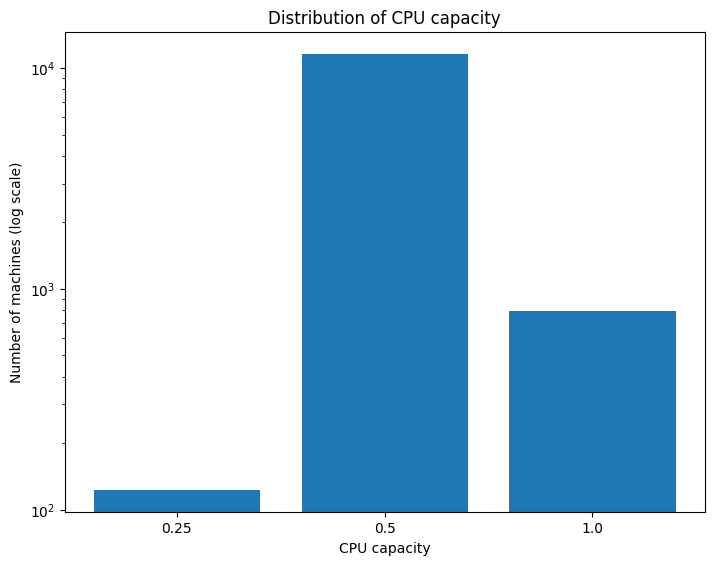

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
legend = cpu_usage.map(lambda x: str(x[0]) if x[0] is not None else 'None').collect()
count = cpu_usage.sortByKey().map(lambda x: x[1]).collect()
ax.bar(legend,count)

plt.xlabel("CPU capacity")
plt.ylabel("Number of machines (log scale)")
plt.title("Distribution of CPU capacity")

plt.yscale("log")
plt.show()

Please mind the y scale which is logarithmic, to better see the lesser frequent CPU capacities.

We observe that a vast majority of machines have half the maximum available CPU power. Less than ten times less machines have the full computational power and even less have a quarter of the maximal power.

### Lost Computational Power due to maintenance (Q2)

In [12]:
machines_history = machine_events \
    .map(lambda row: (machine_id(row),row)) \
    .aggregateByKey(None,lambda acc, e: acc+[e] if acc is not None else [e],add) \
    .map(lambda machine: machine[1])

for a_story in machines_history.take(3):
    print(tabulate(
        a_story,
        headers=schema.get_table_field_names('machine_events'),
        maxcolwidths = [None, None, None, 15, None, None]))
    print('\n')

  time    machine ID    event type  platform ID        CPUs    Memory
------  ------------  ------------  ---------------  ------  --------
     0             6             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=


         time    machine ID    event type  platform ID        CPUs    Memory
-------------  ------------  ------------  ---------------  ------  --------
            0            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
                                           Loni8+J/Yy0RU=
1306164355566            10             1  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
                                           Loni8+J/Yy0RU=
1307163081914            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
       

In [13]:
machines_history.filter(lambda m: sorted(m)).count() - machines_history.count()

0

The trace period starts at 600 seconds (aka $6 \times 10^{8}$ microseconds), to obtain the total trace time, we find the latest event time and subtracted $6 \times 10^{8}$ to it.

In [14]:
from math import ceil

total_trace_time = time(machine_events.max(lambda row: time(row))) - 6*10**8

print(f'The total trace time is {total_trace_time} µs ≈ {ceil(total_trace_time/(10**6 * 3600))} hours ≈ {ceil(total_trace_time/(10**6 * 3600 * 24))} days')

The total trace time is 2505535493517 µs ≈ 696 hours ≈ 29 days


Once we have this number, computing the total computation power of a given machine is a matter of subtracting the starting time of the machine and multiplying by the CPU capacity. We assume here that the CPU capacity of a machine never changes, and we remove the machines that have some cpu values at None to prevent weird events.

In [15]:
def lost_and_total_power(events):
    # Functions and Variables
    status = machine_events_get['event type']
    time = machine_events_get['time']
    start = time(events[0])
    cpu = machine_events_get['CPUs'](events[0])

    # Lost time
    lost_time = 0
    for i,m in enumerate(events):
        if i==0:
            continue
        if status(m)==0 and status(events[i-1])==1:
            lost_time += time(m) - time(events[i-1])
        
    # Total time
    total_time = total_trace_time if (start < 6*10**8) else (total_trace_time - start + 6*10**8)

    # Resulting power
    return (lost_time*cpu,total_time*cpu)

def has_none_cpu(events):
    cpu = machine_events_get['CPUs']
    for m in events:
        if cpu(m) is None:
            return True
    return False

print(f'There are {machines_history.filter(has_none_cpu).count()} machines with None values in their CPUs. They will not be evaluated.')

power_lost_and_total = machines_history \
    .filter(lambda m: not has_none_cpu(m)) \
    .map(lost_and_total_power) \
    .reduce(lambda p1,p2: (p1[0]+p2[0],p1[1]+p2[1]))

print(f'During the trace time, around {(power_lost_and_total[0]/power_lost_and_total[1])*100:.4f}% of the computational power was lost.\
\nThe exact percentage obtained is {(power_lost_and_total[0]/power_lost_and_total[1])*100}% !')


There are 32 machines with None values in their CPUs. They will not be evaluated.
During the trace time, around 0.4798% of the computational power was lost.
The exact percentage obtained is 0.4798129882918588% !


## Distribution of jobs and tasks per scheduling class (Q3)

We will evaluate the distribution over **submitted** tasks and jobs. It also implies that we do not consider the distribution _over time_ but only within the _set_ of all submitted tasks and jobs.

We could also consider the evolution of the scheduling class through time, looking at the event types UPDATE_PENDING and UPDATE_RUNNING. This is a different perspective where time is a key component.

### Studying jobs

We start our analysis with jobs. They should be fewer, as there can be many tasks per job, but one job per task.

Before all, the schema for the tables we will use:

In [16]:
print(tabulate(schema.get_table_schema('job_events')['fields'], headers='keys', maxcolwidths=40))

  field number  content           format       mandatory    formatter
--------------  ----------------  -----------  -----------  --------------------------------------
             0  time              INTEGER      True         <function
                                                            parse_schema_line.<locals>.<lambda> at
                                                            0x7f5b046c79a0>
             1  missing info      INTEGER      False        <function
                                                            parse_schema_line.<locals>.<lambda> at
                                                            0x7f5b005ae680>
             2  job ID            INTEGER      True         <function
                                                            parse_schema_line.<locals>.<lambda> at
                                                            0x7f5b005ae710>
             3  event type        INTEGER      True         <function
                          

First step, gather the events based on the task or job they refer to. We expect such lists of events to be small enough to be handled in regular python lists.

In [17]:
job_events = schema.load_rdd(sc,'job_events')
job_events.persist()

job_events_get = schema.field_getters('job_events')

print(tabulate(job_events.take(10)))

-------------    ----------  -  --------------------------------------------  -  --------------------------------------------  --------------------------------------------
1909868492595    6428560827  1  mbrS6V2tRbksMPO0y8EI9B9XT2ASaPRTNndslCGN/2A=  1  tur2a3qtIIAnEmscQ9ezBuVjYMYLljG6lq82AtxQQoc=  R4IlJBrXJrMe97DPfoV0yvynagxCV2ZeEOoLsQXJjdY=
1909871210758    6428532659  0  0LDWGmHtacCZ9lRhf84At4JNXg9NC0MXWExqxgC12M0=  2  /Mp0R7dBC/iOhCzzqDFfvze5GnMI3SV178LXrBXIzOg=  Z2U5C2yAoFJch4xM2GyffUmIrXNEEyskkwamgREq4/I=
1909872325546    6428531614  4  F2+Gv53Pxd4KDRb/UsGECThH/XUOpcWKElUXJkhkt1c=  0  4m7As6A4qnk1L6sLqKjDi5wPRTDuMYAMkRH+JtWXQXs=  j25eTfDZ4FFHzd7p+VKe13tP4+iQbKkHk9VI0SBK/nE=
1909873285332    6428532659  1  0LDWGmHtacCZ9lRhf84At4JNXg9NC0MXWExqxgC12M0=  2  /Mp0R7dBC/iOhCzzqDFfvze5GnMI3SV178LXrBXIzOg=  Z2U5C2yAoFJch4xM2GyffUmIrXNEEyskkwamgREq4/I=
1909873285336    6428540144  0  0LDWGmHtacCZ9lRhf84At4JNXg9NC0MXWExqxgC12M0=  0  yjXYiJwmUAZ6ukIccIJdJ+4CMMU+rPI/f9zhnJfDPbY=  fEfZo0mZ954hS

In [18]:
print(f"There is an estimated {job_events.countApprox(10)} number of job events")

There is an estimated 2012241 number of job events


On Dorian's machine, the computation above took 1m 46s (with other running jobs such as browser and synchronisation service).

We are interested in the job submission event, which is when they are assigned their (initial) scheduling class.

In [19]:
# event type 0 = SUBMIT
scheduling_events = job_events \
    .filter(lambda job_event: job_events_get['event type'](job_event) == 0)

The documentation says that it is possible for a job to be submitted more than once, when it has evicted, failed or been killed but still is runnable (up to a maximal number of trials).

Do we have any such situation ?

In [20]:
jobs_with_several_scheduling_classes = scheduling_events \
    .map(lambda job_event: (job_events_get['job ID'](job_event), 
                            [job_events_get['scheduling class'](job_event)])) \
    .reduceByKey(lambda event1, event2: event1 + event2) \
    .filter(lambda x: len(x[1]) > 1) \
    .count()

print(f'{jobs_with_several_scheduling_classes} jobs have more than one scheduling class.')

1 jobs have more than one scheduling class.


No.

Let us then proceed with gathering the scheduling classes.

In [21]:
job_scheduling_classes = scheduling_events \
    .map(lambda event: (job_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in job_scheduling_classes:
    print(scheduling_class)

(0, 257276)
(1, 215109)
(2, 194513)
(3, 5177)


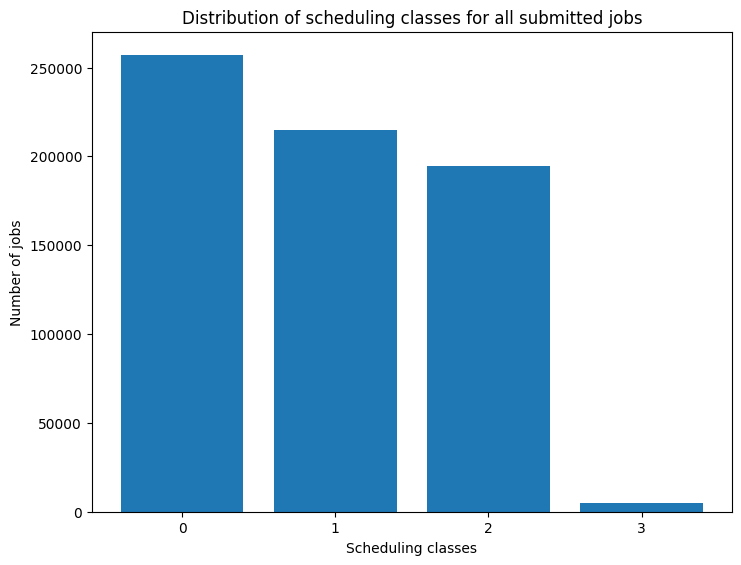

In [22]:
def bar_plot_question3(scheduling_classes, title):
    # TODO : make this into a proper function and put it in another file (plot.py ?)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    scheduling_class = list(map(lambda x: x[0], scheduling_classes))
    count = list(map(lambda x: x[1], scheduling_classes))
    ax.bar(scheduling_class,count)
    plt.xlabel("Scheduling classes")
    plt.ylabel("Number of jobs")
    plt.xticks(scheduling_class)
    plt.title(title)
    plt.show()

bar_plot_question3(job_scheduling_classes, "Distribution of scheduling classes for all submitted jobs")

### Repeating the analysis for tasks

Let us now do the same analysis for all tasks, irrespective of which job they belong to.

Starting with the schema of the tasks events table

In [23]:
task_events_get = schema.field_getters('task_events')

print(tabulate(
    schema.get_table_schema('task_events')['fields'], 
    headers='keys',
    maxcolwidths=[None, 20, None, None, 40]))

  field number  content             format       mandatory    formatter
--------------  ------------------  -----------  -----------  --------------------------------------
             0  time                INTEGER      True         <function
                                                              parse_schema_line.<locals>.<lambda> at
                                                              0x7f5b005ae830>
             1  missing info        INTEGER      False        <function
                                                              parse_schema_line.<locals>.<lambda> at
                                                              0x7f5b005ae8c0>
             2  job ID              INTEGER      True         <function
                                                              parse_schema_line.<locals>.<lambda> at
                                                              0x7f5b005aea70>
             3  task index          INTEGER      True         <function
  

Then, we load the data and filter for submission events.

In [24]:
task_events = schema.load_rdd(sc,'task_events').persist()

task_submit_events = task_events.filter(
    lambda task_event: task_events_get['event type'](task_event) == 0)

# task_headers = map(lambda field: field['content'], task_events_schema['fields'])
# print(tabulate(task_submit_events.take(5), headers=task_headers))
for task_event in task_submit_events.take(5):
    print(task_event)

[125880666625, None, 515042969, 17, None, 0, '/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=', 2, 0, 0.01562, 0.01553, 0.0002155, False]
[125880666637, None, 515042969, 19, None, 0, '/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=', 2, 0, 0.01562, 0.01553, 0.0002155, False]
[125881649347, None, 6238340468, 622, None, 0, '1wRYrkVgrhQf/fNZQV2VHyG306siaFFyZMEM1r1cW2E=', 1, 0, 0.0625, 0.03961, 3.815e-05, False]
[125881676818, None, 6238340468, 249, None, 0, '1wRYrkVgrhQf/fNZQV2VHyG306siaFFyZMEM1r1cW2E=', 1, 0, 0.0625, 0.03961, 3.815e-05, False]
[125881676828, None, 6238340468, 2363, None, 0, '1wRYrkVgrhQf/fNZQV2VHyG306siaFFyZMEM1r1cW2E=', 1, 0, 0.0625, 0.03961, 3.815e-05, False]


In [25]:
tasks_with_several_scheduling_classes = task_submit_events \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), 
                        {task_events_get['scheduling class'](event)})) \
    .reduceByKey(lambda event1, event2: event1 | event2) \
    .filter(lambda x: len(x[1]) > 1)

print(f'{tasks_with_several_scheduling_classes.count()} tasks have more than one scheduling class.')

0 tasks have more than one scheduling class.


From this, we conclude that, as with jobs, no task has ever seen its scheduling class changed after being resubmitted (due to eviction, failure, kill).

In [26]:
task_scheduling_classes = task_submit_events \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in task_scheduling_classes:
    print(scheduling_class)

(0, 5633188)
(1, 1218508)
(2, 358848)
(3, 51384)


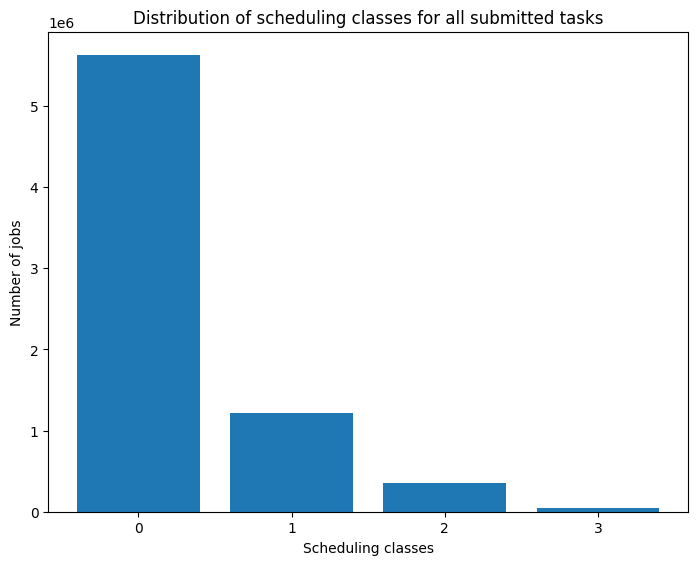

In [27]:
bar_plot_question3(task_scheduling_classes, "Distribution of scheduling classes for all submitted tasks")

## Relation between scheduling class and eviction of tasks (Q4)

In [28]:
scheduling_eviction_relations = task_events \
    .filter(lambda event: task_events_get['event type'](event) == 2) \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0])

for relations in scheduling_eviction_relations.collect():
    print(relations)

(0, 740876)
(1, 232409)
(2, 90950)
(3, 8590)


Tasks with lower scheduling class were evicted much more than those with higher scheduling class. Note that we chose to keep all eviction events, even when a single task is evicted several times.

It matches the idea that latency-sensitive tasks, represented with higher scheduling classes, need to be interrupted (namely evicted) as little as possible, so that they can be completed soon.

## Same Job -> Same machine ? (Q5)

We here take into account every task with the same job, and for each index we determine the number of machine used.

2169714 tasks have 1 or 2 machines.
271165 tasks have more than 2 machines.


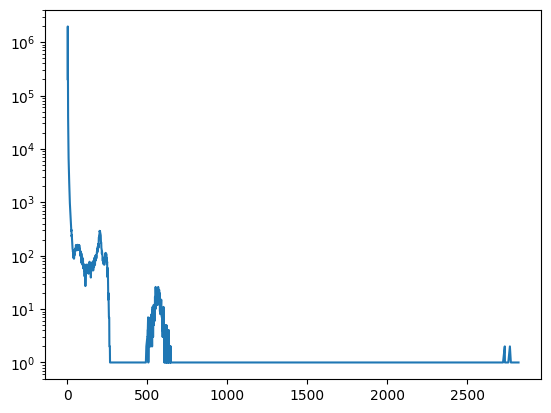

In [29]:
nb_machines_per_job = task_events \
    .map(lambda event: ((task_events_get["job ID"](event),task_events_get["task index"](event)),{task_events_get["machine ID"](event)})) \
    .reduceByKey(lambda machine1,machine2: machine1 | machine2) \
    .map(lambda job: len(job[1])) 

same_and_different_distribution = nb_machines_per_job \
    .map(lambda count: "1 or 2" if count<=2 else "more than 2") \
    .countByValue() \
    .items()

for stat in same_and_different_distribution:
    print(f"{stat[1]} tasks have {stat[0]} machines.")

final = list(nb_machines_per_job.countByValue().items())
final.sort(key=lambda x:x[0])

plt.plot(*zip(*final))
plt.yscale("log")
plt.show()

As we can see, it is indeed most common to have our tasks from the same job run on 1 or 2 machines.

## Comparison of resource request and resource usage for tasks (Q6)

This topic requires to do the analysis for three different resources: CPU cores, RAM and disk space. To start with, and become acquainted with the question at hand, we start with the CPU.

### Resource requests

Tasks can specify resource requirements when SUBMITTED (0) and upon UPDATE_PENDING (7) and UPDATE_RUNNING (8) events. Do they actually update their resource requests ?

In [30]:
resource_requests = task_events \
    .filter(lambda event: task_events_get['CPU request'](event) is not None \
        and task_events_get['memory request'](event) is not None \
        and task_events_get['disk space request'](event) is not None) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)),
        ({task_events_get['CPU request'](event)}, \
        {task_events_get['memory request'](event)}, \
        {task_events_get['disk space request'](event)}))) \
    .reduceByKey(lambda r1, r2: (r1[0] | r2[0], r1[1] | r2[1], r1[2] | r2[2]))

multiple_requests = resource_requests.filter(lambda event: len(event[1][0]) > 1 or len(event[1][1]) > 1 or len(event[1][2]) > 1)

print(f"There has been {multiple_requests.count()} tasks changing their resource requests during their lifetime over a total of {resource_requests.count()}, accounting for {multiple_requests.count() / resource_requests.count() * 100}%. Here is a sample of those:")

for req in multiple_requests.take(5):
    print(f"- task {req[0]} requested the following resources: {req[1]}")

There has been 37559 tasks changing their resource requests during their lifetime over a total of 2440879, accounting for 1.5387489506853884%. Here is a sample of those:
- task (4707865726, 44) requested the following resources: ({0.0625, 0.1514}, {0.01746, 0.2327}, {0.003395, 0.0006104})
- task (6176858948, 1771) requested the following resources: ({0.01874, 0.0625}, {0.05316, 0.003109}, {0.000308, 2.67e-05})
- task (5950955866, 46) requested the following resources: ({0.03125, 0.06567}, {0.01605, 0.09778}, {9.06e-05, 9.155e-05})
- task (6176871439, 88) requested the following resources: ({0.01874, 0.0625}, {0.05316, 0.003887}, {0.000308, 2.67e-05})
- task (6176871439, 1393) requested the following resources: ({0.01874, 0.0625}, {0.05316, 0.003887}, {0.000308, 2.67e-05})


Many tasks made more than one resource request in their lifetime.

Let us also see when the CPU request is made. Is it only done at submit time or later ?

In [31]:
print(task_events.filter(lambda event: task_events_get['CPU request'](event) is not None) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)),
        (task_events_get['event type'](event), task_events_get['time'](event)))) \
    .reduceByKey(lambda event1, event2: event1 if event1[1] < event2[1] else event2) \
    .map(lambda entry: entry[1][0]) \
    .countByValue())

defaultdict(<class 'int'>, {0: 2307875, 1: 133004})


We see that the vast majority of CPU requests are made at task submission. When it is not the case, the earliest CPU request is at scheduling. To our understanding, the SCHEDULE (1) event is caused by the system, not by the user, so we choose to only keep CPU requests defined at submission.

Removing the tasks who make several different CPU requests.

In [32]:
cpu_changing_events = task_events \
    .filter(lambda event: task_events_get['CPU request'](event) is not None) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)),
        {task_events_get['event type'](event)})) \
    .reduceByKey(lambda cpu_request1, cpu_request2: cpu_request1 | cpu_request2) \
    .cache()

for event in cpu_changing_events.map(lambda event: frozenset(event[1])).distinct().collect():
    print(event)

frozenset({0, 1, 3, 5, 7, 8})
frozenset({8, 1})
frozenset({0, 1, 3, 7, 8})
frozenset({0, 1, 2, 3, 5, 8})
frozenset({0})
frozenset({0, 1, 2, 3, 4, 5})
frozenset({0, 1, 4, 6})
frozenset({0, 1, 5})
frozenset({0, 1, 2, 3, 6})
frozenset({0, 1, 3, 4})
frozenset({0, 1, 2, 4, 5, 6})
frozenset({0, 1, 2, 4, 5})
frozenset({1})
frozenset({0, 1, 2, 3})
frozenset({0, 1, 5, 6})
frozenset({8, 0, 1})
frozenset({0, 1, 3, 8})
frozenset({0, 1, 4})
frozenset({0, 2, 5})
frozenset({0, 6})
frozenset({0, 1, 3, 4, 5})
frozenset({0, 1, 2, 4, 6})
frozenset({0, 1, 2, 5, 7})
frozenset({0, 1})
frozenset({0, 1, 2, 3, 5, 7})
frozenset({0, 1, 5, 8})
frozenset({0, 1, 2, 3, 4})
frozenset({0, 1, 3, 5})
frozenset({0, 5})
frozenset({0, 1, 2, 6})
frozenset({0, 1, 3})
frozenset({0, 1, 2, 5, 6})
frozenset({0, 1, 4, 5})
frozenset({0, 1, 3, 5, 8})
frozenset({0, 1, 2, 5})
frozenset({0, 1, 2, 4})
frozenset({0, 4})
frozenset({0, 1, 3, 6})
frozenset({1, 5})
frozenset({0, 1, 2, 8})
frozenset({0, 1, 2, 5, 8})
frozenset({0, 1, 2})
froz

In [33]:
task_events \
    .filter(lambda event: task_events_get['CPU request'](event) is not None and task_events_get['event type'](event) == 0) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), 1)) \
    .reduceByKey(add) \
    .count()

2440751

In [34]:
resource_requests = task_events \
    .filter(lambda event: task_events_get['CPU request'](event) is not None \
        and task_events_get['memory request'](event) is not None \
        and task_events_get['disk space request'](event) is not None \
        and task_events_get['event type'](event) == 0) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)),
        (task_events_get['CPU request'](event),task_events_get['memory request'](event),task_events_get['disk space request'](event)))) \
    .reduceByKey(lambda r1, r2: r1 if r1 == r2 else None) \
    .filter(lambda event: event[1] is not None) \
    .cache()

In [35]:
for request in resource_requests.take(5):
    print(request)

((5950955866, 47), (0.03125, 0.01605, 9.155e-05))
((6266791942, 57), (0.0625, 0.0318, 0.0007715))
((6266791942, 146), (0.0625, 0.0318, 0.0007715))
((6266791942, 147), (0.0625, 0.0318, 0.0007715))
((6266791942, 244), (0.0625, 0.0318, 0.0007715))


### Resource usage table

The resource usage information is stored in its own table. We will have to learn to use it, and also to match its data with the task events.

It is to be noted that resource measurement periods might overshoot after a task is killed. We might want to remove these parts of the measurements, if they prove problematic.

The documentation for the data set also specifies how the maximum measurement data is aggregated (for sub-containers), and gives a field in the table for this information. I believe, for the sake of this work, that we can spare ourselves the extra mileage of using this field, and just consider that the measurements are accurate enough.

First thing first, loading the related data set:

In [36]:
task_usage_get = schema.field_getters('task_usage')
task_usage = schema.load_rdd(sc,'task_usage')
task_usage.cache()

for elem in task_usage.take(5):
	print(elem)

[5612000000, 5700000000, 4665712499, 369, 4820204869, 0.03143, 0.05389, 0.06946, 0.005997, 0.006645, 0.05408, 7.629e-05, 0.0003834, 0.2415, 0.002571, 2.911, None, 0.0, False, 0.02457]
[5612000000, 5700000000, 4665712499, 798, 3349189123, 0.02698, 0.06714, 0.07715, 0.004219, 0.004868, 0.06726, 7.915e-05, 0.0003681, 0.27, 0.00293, 3.285, 0.008261, 0.0, False, 0.01608]
[5612000000, 5700000000, 4665896876, 251, 372630265, 0.04114, 0.06714, 0.07739, 0.002956, 0.003605, 0.0675, 0.0001135, 0.000371, 0.1086, 0.004784, 1.551, 0.002311, 0.0, False, 0.05286]
[5612000000, 5613000000, 5285926325, 0, 2850406, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, None, None, 0.0, False, 0.0]
[5612000000, 5700000000, 6000618870, 74, 1437119225, 0.07275, 0.01898, 0.02716, 0.0008469, 0.002251, 0.01901, 0.0, 0.0, 0.2415, 0.0, 1.3, 0.0005437, 0.0, False, 0.06238]


Measurement records may be missing, not implying that a task is not running. Let us count how many such missing records there are, and how many tasks (ratio) are affected.

In [37]:
resource_fields = [
        'start time',
        'end time',
        'CPU rate',
        'canonical memory usage',
        'local disk space usage'
    ]

def entry_converter(entry):
    return tuple(task_usage_get[field](entry) for field in resource_fields)

def aggregator(accumulator, resource_usage):
    accumulator[0] += resource_usage[1]-resource_usage[0]
    for i in range(2,len(resource_usage)):
        accumulator[i-1] += resource_usage[0]*resource_usage[i]
    return accumulator

from operator import add
def combiner(accumulator1, accumulator2):
    return list(map(add, accumulator1, accumulator2))

resources_per_task = task_usage \
    .map(lambda entry: ((task_usage_get['job ID'](entry), task_usage_get['task index'](entry)),
        entry_converter(entry))) \
    .aggregateByKey([0,]*(len(resource_fields)-1), aggregator, combiner) \
    .cache()

In [38]:
print(f"There are {resources_per_task.count()} tasks for which we have resource consumption data.")

There are 197032 tasks for which we have resource consumption data.


In [39]:
for entry in resources_per_task.take(1):
    print(entry[0])
    # print(entry[1])
    for x in entry[1]:
        print(x)

(6218406404, 1085)
3742000000
549308957.1
83101644.5
17030.2209


In [40]:
joined = resource_requests \
    .join(resources_per_task) \
    .map(lambda x: (x[1][0], *x[1][1])) \
    .sortBy(lambda x: x[0]) \
    .cache()

In [41]:
for x in joined.take(5):
    print(x)

((0.0, 0.0, 0.0), 9657000000, 14938228.77, 85873695.79999998, 0.0)
((0.0, 0.0, 0.0), 10200000000, 1502556.3, 22338810.0, 0.0)
((0.0, 0.0001554, 0.0), 20000000, 705389.63, 0.0, 0.0)
((0.0, 0.0001554, 0.0), 15000000, 982104.5, 0.0, 0.0)
((0.0, 0.0001554, 0.0), 17000000, 630080.88, 0.0, 0.0)


In `joined`, the first element is a tuple of the requests for CPU, RAM, and storage space, and the following is respectively

- the cumulated duration of the task,
- the total amount of CPU.s for the task,
- the RAM used,
- the disk storage used.

In [42]:
cpu_req_vs_coresec = joined \
    .map(lambda x: (x[0][0],(x[2],1))) \
    .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1])) \
    .map(lambda x: (x[0],x[1][0]/x[1][1]))\
    .sortByKey()\
    .collect()

mem_req_vs_coresec = joined \
    .map(lambda x: (x[0][1],(x[3],1))) \
    .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1])) \
    .map(lambda x: (x[0],x[1][0]/x[1][1]))\
    .sortByKey()\
    .collect()

disk_req_vs_coresec = joined \
    .map(lambda x: (x[0][2],(x[4],1))) \
    .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1])) \
    .map(lambda x: (x[0],x[1][0]/x[1][1]))\
    .sortByKey()\
    .collect()

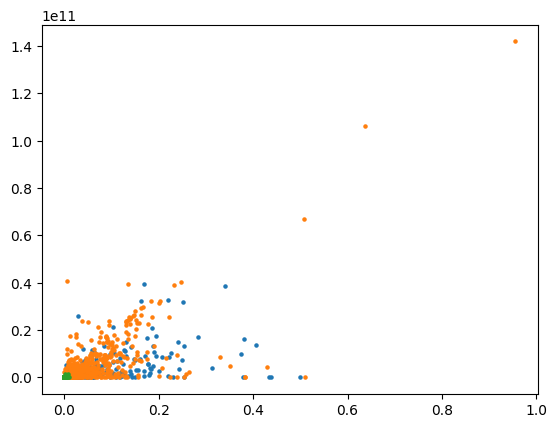

In [43]:
S=5

plt.scatter(*zip(*cpu_req_vs_coresec),s=S)
plt.scatter(*zip(*mem_req_vs_coresec),s=S)
plt.scatter(*zip(*disk_req_vs_coresec),s=S)
# plt.yscale("log")
plt.show()

Below, the code `.map(lambda x: (x[0],x[1][0]/x[1][1]))` performs averaging

In [44]:
cpu_req_vs_core = joined \
    .map(lambda x: (x[0][0],(x[2]/x[1],1))) \
    .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1])) \
    .map(lambda x: (x[0],x[1][0]/x[1][1]))\
    .sortByKey()\
    .collect()

mem_req_vs_core = joined \
    .map(lambda x: (x[0][1],(x[3]/x[1],1))) \
    .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1])) \
    .map(lambda x: (x[0],x[1][0]/x[1][1]))\
    .sortByKey()\
    .collect()

disk_req_vs_core = joined \
    .map(lambda x: (x[0][2],(x[4]/x[1],1))) \
    .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1])) \
    .map(lambda x: (x[0],x[1][0]/x[1][1]))\
    .sortByKey()\
    .collect()

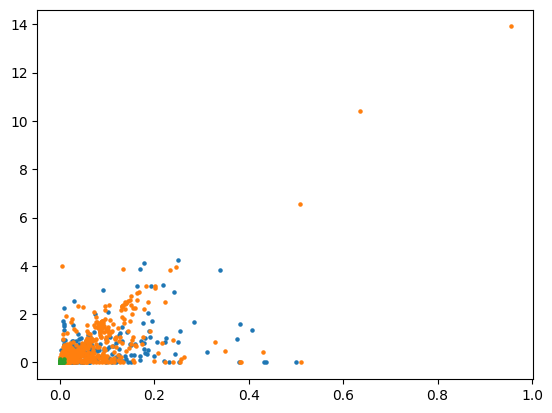

In [45]:
plt.scatter(*zip(*cpu_req_vs_core),s=S)
plt.scatter(*zip(*mem_req_vs_core),s=S)
plt.scatter(*zip(*disk_req_vs_core),s=S)
#plt.xscale("log")
plt.show()

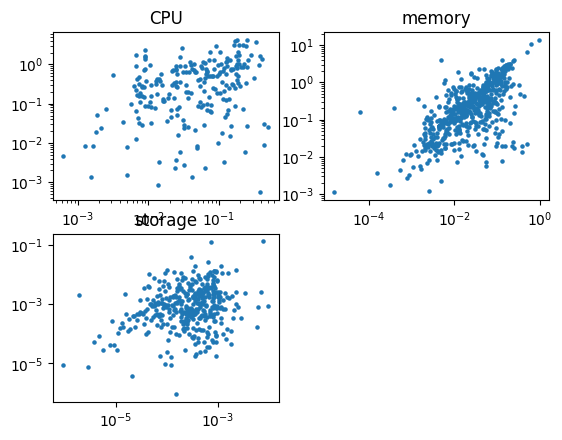

In [46]:
rspl = plt.subplot(2, 2, 1)
rspl.scatter(*zip(*cpu_req_vs_core),s=S)
plt.yscale("log")
plt.xscale("log")
plt.title("CPU")
rspl = plt.subplot(2, 2, 2)
rspl.scatter(*zip(*mem_req_vs_core),s=S)
plt.yscale("log")
plt.xscale("log")
plt.title("memory")
rspl = plt.subplot(2, 2, 3)
rspl.scatter(*zip(*disk_req_vs_core),s=S)
plt.yscale("log")
plt.xscale("log")
plt.title("storage")
plt.show()

These plots shows that, in general, there are no trends regarding the CPU and Disk requests vs their real usage. However, we can clearly see that there is one for the memory.

## Relation between resource usage peaks and task evictions (Q7)

We will investigate, for any given machine, whether there is a correlation  between resource consumption peaks and task evictions.

### Objective

To find a correlation, we will first construct a timeline, for each machine, of the maximum resource used, and the eviction events. Fortunately, the table Task Usage contains data on the maximum resource used withing a given time window. As such, we just need to correlate these resources with the eviction events. The documentation does not mention that tasks are migrated between machines, so we do not have to account for that.

Moreover, in the documentation we learn that the traces in our task usage data are done withing periods of 300 seconds starting at 600 seconds in the timeline. As such, to have a dataset easier to look at and perform operations on, we will form our timeline in epochs starting from 0. The first epoch 0 will therefore belongs to the time frame between 600s and 900s, epoch 1 will be between 900s and 1200s and so on.

Doing so, we find that there are 17 epochs in total for both task usage and task events.

Below are some tests showing that no task usage recording are in between epochs :

In [47]:
overlapping_epochs = task_usage \
    .map(lambda task: ((task_usage_get['start time'](task), task_usage_get['end time'](task)), 0)) \
    .filter(lambda x: x[0][0]//300000000!=(x[0][1]-1)//300000000).count()
    # The -1 on the end time is to account for the events that ends at the end of an epoch (ex : 675s -> 900s is still withing epoch 0)
    

print(f"The number of events not inside a 300s period or epoch is {overlapping_epochs}.")


The number of events not inside a 300s period or epoch is 0.


### Gathering task consumption peaks for all machines

The machine resource table contains machine IDs, so we can gather task consumption peaks for all machines on the one hand, and then task eviction events for all machines on the other hand. We can assume that no task can trigger two events at the same time, so we can ignore job ID and task index and only keep the machine ID.

We gather all maximum resource values for each machine, and their epochs. This should allow to later plot, or do some form of aggregation, for instance the count of values above a threshold.

In [48]:
def event_to_peak_resources(event):
    return {(task_usage_get['start time'](event)-600000000)//300000000 : 
                (task_usage_get['maximum CPU rate'](event), 
                task_usage_get['maximum memory usage'](event), 
                task_usage_get['maximum disk IO time'](event))
            }

def fuse_max_dictionary(d1,d2):
    for element in d2:
        if element in d1:
            a1, a2, a3 = d1[element]
            b1, b2, b3 = d2[element]
            d1[element] = (max(a1,b1),max(a2,b2),max(a3,b3))
        else :
            d1[element] = d2[element]
    return d1

default_dict = dict.fromkeys([a for a in range(0,34)],(.0,.0,.0))


machines_max_usage = task_usage \
    .filter(lambda event: task_usage_get['maximum memory usage'](event) is not None and \
        task_usage_get['maximum CPU rate'](event) is not None and \
        task_usage_get['maximum disk IO time'](event) is not None \
    ) \
    .map(lambda event: 
        (task_usage_get['machine ID'](event),
        event_to_peak_resources(event))) \
    .foldByKey(default_dict,lambda measurement1, measurement2: fuse_max_dictionary(measurement1,measurement2)) \
    .map(lambda machine: (machine[0],
            ([k for k,_ in machine[1].items()],
            [v[0] for _,v in machine[1].items()],
            [v[1] for _,v in machine[1].items()],
            [v[2] for _,v in machine[1].items()])
            )
        )\
    .cache()

### Gathering task eviction events for all machines

So, we mapped machine IDs to the related resource information we have. Let us now map machine IDs to eviction events. Joining the two should give us something we can analyze.

In [49]:
from numpy import histogram,arange

def check(list):
    for e in list:
        if e!=0:
            return True
    return False

task_evict_events = task_events \
    .filter(lambda task_event: task_events_get['event type'](task_event) == 2) \
    .map(lambda event: (
            task_events_get['machine ID'](event),
            [(
                (task_events_get['time'](event)-600000000)//300000000
            )]
        )
    ) \
    .reduceByKey(lambda events1, events2: events1 + events2) \
    .mapValues(lambda v : list(histogram(v,arange(35))[0])) \
    .filter(lambda x: check(x[1])) \
    .cache()

### Correlation Study

Now, how do we associate these two sets of values ? A simple join is enough as we need to correlate datasets with the same machine ID.

In [50]:
correlation = machines_max_usage.join(task_evict_events).mapValues(lambda x: (*x[0],x[1])).cache()

Now that we have our data for each machines, we need to correlate the eviction events and max resource usage for each periods. To do so we will first try to determine the correlation coefficient (also known as ***Pearson Correlation Coefficient***) for each machine and each resource usage. To do so we use the already existing *numpy* function *corrcoef*.

In [ ]:
import numpy as np

coef = correlation.map(lambda e: ( \
    [np.corrcoef(np.array(e[1][4]),np.array(e[1][1]))[1][0]],\
    [np.corrcoef(np.array(e[1][4]),np.array(e[1][2]))[1][0]],\
    [np.corrcoef(np.array(e[1][4]),np.array(e[1][3]))[1][0]] \
)).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2]))

In [52]:
from statistics import mean,median

max_coef = tuple([max(e) for e in coef])
min_coef = tuple([min(e) for e in coef])
average_coef = tuple([mean(e) for e in coef])
median_coef = tuple([median(e) for e in coef])

print(f"Maximum coefficients found : {max_coef}\nMinimum coefficients found : {min_coef}\nAverage of all coefficients : {average_coef}\nMedian coefficients : {median_coef}")

Maximum coefficients found : (0.9780996399005489, 1.0, 0.7786835576588109)
Minimum coefficients found : (-0.686292601076302, -0.999905756749502, -0.5688337699851276)
Average of all coefficients : (0.12192521190042006, nan, 0.07779399506536094)
Median coefficients : (0.09863104721262035, -0.04844101105048903, 0.0645486558407862)


As we can see, there are machines that seems to have correlations between the maximum resource used and the number of evictions, but the whole data (especially the mean and median) suggest that no such correlation exists.

If we don't try to look at the coefficients machine by machine, but try to find the correlation coefficient of the whole data set (while keeping X being the maximum resource used and Y the number of eviction), we obtain the following numbers :

In [53]:
cpu = correlation.map(lambda e: (e[1][1],e[1][4])).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))
memory = correlation.map(lambda e: (e[1][2],e[1][4])).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))
disk = correlation.map(lambda e: (e[1][3],e[1][4])).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))

print(np.corrcoef(np.array(cpu[0]),np.array(cpu[1]))[1][0])
print(np.corrcoef(np.array(memory[0]),np.array(memory[1]))[1][0])
print(np.corrcoef(np.array(disk[0]),np.array(disk[1]))[1][0])

0.06332681225544091
-0.006154405757861686
0.013822448895748152


As such, we can safely conclude that there are no correlation, negative of positive, between the picks of resources of a machine and its eviction events. 

Just for the sake of eye candy, here are the plots for each resource types maximum usage vs task evictions, where we can clearly see no correlations :

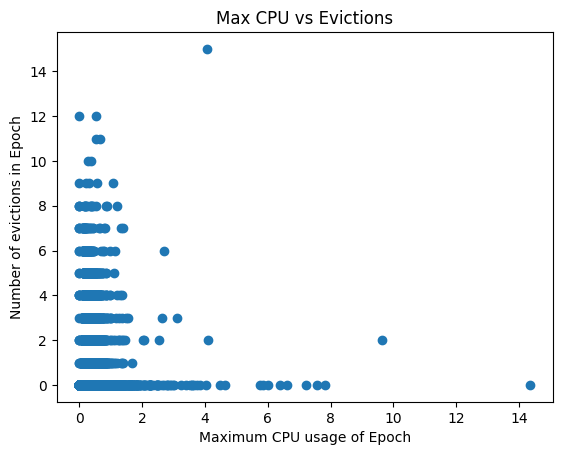

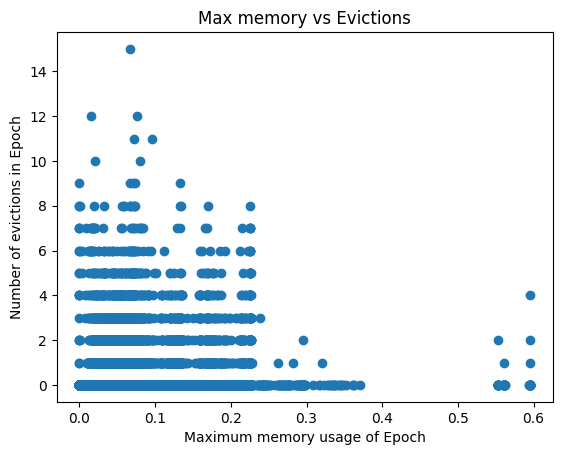

Text(0, 0.5, 'Number of evictions in Epoch')

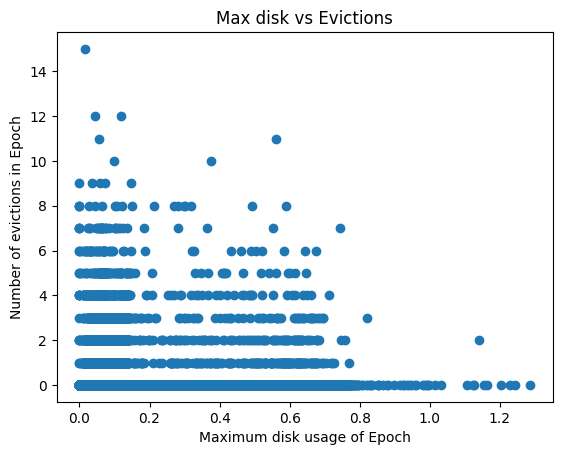

In [54]:
plt.scatter(*cpu)
plt.title("Max CPU vs Evictions")
plt.xlabel("Maximum CPU usage of Epoch")
plt.ylabel("Number of evictions in Epoch")
plt.show()
plt.scatter(*memory)
plt.title("Max memory vs Evictions")
plt.xlabel("Maximum memory usage of Epoch")
plt.ylabel("Number of evictions in Epoch")
plt.show()
plt.scatter(*disk)
plt.title("Max disk vs Evictions")
plt.xlabel("Maximum disk usage of Epoch")
plt.ylabel("Number of evictions in Epoch")

## Additional Questions (added by us)

Here are the final 2 questions that we came up with, each have their precisions to explain what it is we are looking for.

### 1 - Study of the relation between Scheduling Class and Dead Time

The Google documentation tells us that scheduling classes have different levels of latency, with 3 supposedly having lower latency than 0. It also tells us that when a task dies (failed, evicted, etc.), the scheduler tries to submit it again as soon as possible. As such, we can verify the first statement by looking at the average time spent being dead for each classes. We should expect class 0 to have the most, and class 3 the least.

First, let's remind ourself of the distribution of scheduling classes : 

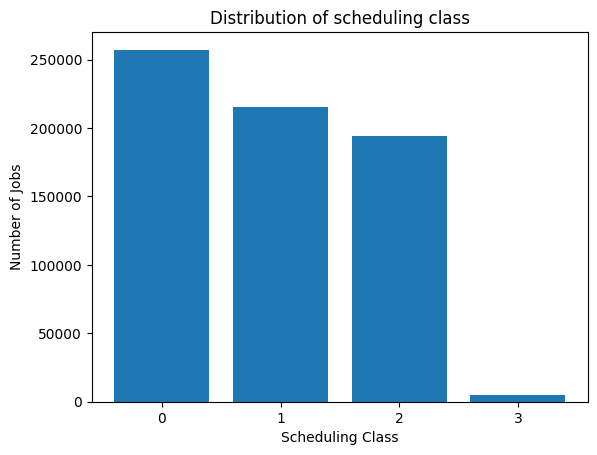

In [55]:
classes, hist = zip(*job_scheduling_classes)
classes = [str(e) for e in classes]
plt.bar(classes, hist)
plt.title("Distribution of scheduling class")
plt.xlabel("Scheduling Class")
plt.ylabel("Number of Jobs")
plt.show()

Now let us form the timeline of each jobs, then perform the necessary transformations to have the average death time for each class.

In [56]:
jobs_timeline = job_events \
    .filter(lambda event: job_events_get['event type'](event) not in {7,8}) \
    .map(lambda event: (
        (job_events_get['job ID'](event),job_events_get['scheduling class'](event)),
        (job_events_get['time'](event), job_events_get['event type'](event))
        )
    ) \
    .groupByKey() \
    .mapValues(list) \
    .cache()

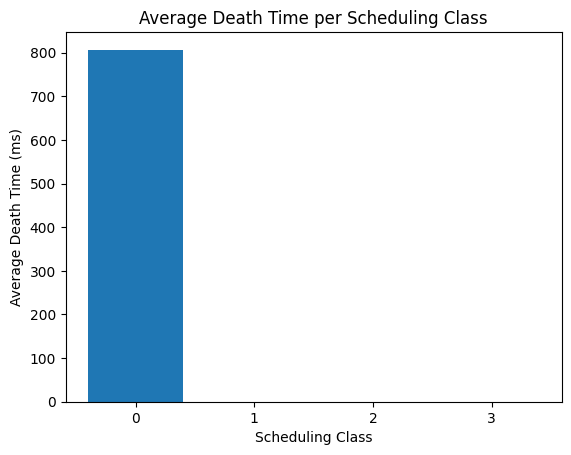

In [57]:
def death_times(s_class, timeline):
    timeline.sort(key=lambda x: x[0])
    all_deaths = []
    for i in range(1,len(timeline)):
        if timeline[i-1][1] in {2,3,4,5,6} and timeline[i][1] == 0:
            all_deaths += [(s_class,timeline[i][0] - timeline[i-1][0])]
    if all_deaths == []:
        return [(s_class,0)]
    return all_deaths

average_death_duration_per_class = jobs_timeline \
    .flatMap(lambda job: death_times(job[0][1],job[1])) \
    .aggregateByKey(
        (0,0),
        lambda acc, data : (acc[0] + data, acc[1] + 1),
        lambda acc1, acc2 : (acc1[0] + acc2[0], acc1[1] + acc2[1])
    ).mapValues(lambda v: v[0]/v[1])

_ , data_death_time = zip(*average_death_duration_per_class.sortByKey().collect())
plt.bar([str(c) for c in range(4)],data_death_time)
plt.title("Average Death Time per Scheduling Class")
plt.xlabel("Scheduling Class")
plt.ylabel("Average Death Time (ms)")
plt.show()

We can see from the above graph and raw data that scheduling class 0 is the only class with any visible latency, which is slightly unexpected but does not contradict what was said in the google documentation.

### 2 - Task priority impact 

Is there a positive correlation between a task priority and the ratio of its life spent running. Logic would say that it does, as this is what we would expect the scheduler to do.

Preliminary questions:
- Can a task change priority level ?
- Do some tasks not have a FINISH (4) event at the end of their timeline ?

In [58]:
nb_tasks_several_priorities = task_events.map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), {task_events_get['priority'](event)})) \
    .reduceByKey(lambda p1, p2: p1 | p2) \
    .filter(lambda task: len(task[1])>1) \
    .count()

print(f"There are {nb_tasks_several_priorities} tasks that have changed priorities.")

tasks_last_event_distribution = task_events \
    .map(lambda event: (
        (task_events_get['job ID'](event), task_events_get['task index'](event)),
        (task_events_get['time'](event), task_events_get['event type'](event))
        )
    ) \
    .reduceByKey(lambda e1,e2: e1 if e1[0] > e2[0] else e2) \
    .map(lambda event : (event[1][1],1)) \
    .reduceByKey(add) \
    .sortBy(lambda e: e[0]) \
    .collect()

print(f"The distribution of last events are as follows :\n{tabulate(tasks_last_event_distribution)}")


There are 142 tasks that have changed priorities.


The distribution of last events are as follows :
-  -------
0    21292
1   128291
2     1053
3     3339
4  1554453
5   731765
6      486
8      200
-  -------


Considering what we see, we need to filter events that have actually finished to have a relevant dataset for our question, as a task with high priority could have had a short life without running, getting a poor ratio. 

Now that we know that, we just need to look at each task's timelines (similar to how we did it in question 2) and determine its running time, and whole life. 
We will need to determine the running time out of all it's life. The running time is the time between the events SCHEDULE (1) and either EVICT (2), FINISHED (4), FAIL (3), KILL (5), or LOST (6).

We will filter out the updates events, as they do not change the running status of our tasks.

In [59]:
tasks_timeline = task_events \
    .filter(lambda event: task_events_get['event type'](event) not in {7,8}) \
    .map(lambda event: (
        (task_events_get['job ID'](event), task_events_get['task index'](event), task_events_get['priority'](event)),
        (task_events_get['time'](event), task_events_get['event type'](event))
        )
    ) \
    .aggregateByKey(None,lambda acc, e: acc+[e] if acc is not None else [e],add) \
    .filter(lambda task: task[1][-1][1] == 4) \
    .cache()

# print(f"We have a total of {tasks_timeline.count()} tasks timelines.")

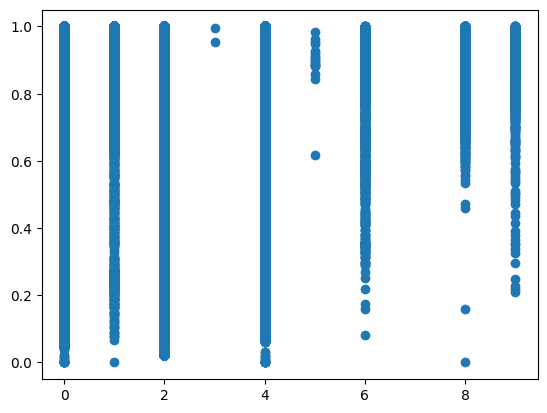

In [60]:
def running_ratio(timeline):
    timeline.sort(key=lambda x: x[0])
    total_time = timeline[-1][0] - timeline[0][0]
    if total_time==0 :
        total_time = 1
    running_time = 0
    for i in range(1,len(timeline)):
        if timeline[i-1][1] == 1 and timeline[i][1] in {2,3,4,5,6}:
            running_time += timeline[i][0] - timeline[i-1][0]
    return float(running_time) / float(total_time)

tasks_ratio = tasks_timeline.map(lambda task: (task[0][2],running_ratio(task[1])))

plt.scatter(*zip(*tasks_ratio.collect()))
plt.show()

Seeing all points does not help us, so let's see the average for each priority level.

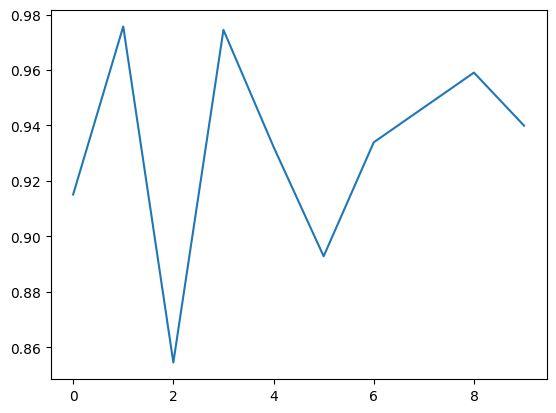

In [61]:
tasks_average_ratio = tasks_ratio \
    .map(lambda task: (task[0],(task[1],1))) \
    .reduceByKey(lambda t1,t2: (t1[0]+t2[0],t1[1]+t2[1])) \
    .map(lambda task: (task[0],task[1][0]/task[1][1]))

plt.plot(*zip(*tasks_average_ratio.collect()))
plt.show()

These results are very unexpected, the google documentation (page 8, Task events table section) clearly states that 0 is the lowest priority. But the document also states that there are 3 priority categories :
- free : lowest priority
- production : highest priorities
- monitoring : special category for jobs that monitor others

It might be that the ranges we see are those 3 categories, with 0 to 2 being "free", 3 to 8 being "production", and 9 to 11 being monitoring. Maybe monitoring has low ratios because it gets evicted often for long period monitoring, it does not need to run often, and therefore produces a lower ratio overall.